## 1. Import Dependencies ##

In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

## 2. Data Collection and Prepocessing ##

In [2]:
# Fetch BEP daily stock data
BEP_data = yf.download('BEP', start='2011-12-01', end='2023-10-17', interval='1d')

# Reset the index to convert 'Date' from index to a regular column
BEP_data.reset_index(inplace=True)

# Drop unnecessary 'Close' column and renamed the Adj Close column
BEP_data.drop(columns=['Close'], inplace=True, errors='ignore')
BEP_data.rename(columns={'Adj Close': 'Adjusted_Close'}, inplace=True, errors='ignore')

# Drop rows with missing values
BEP_data.dropna(inplace=True)

# Calculate daily returns and volume change
BEP_data['Returns'] = BEP_data['Adjusted_Close'].pct_change()
BEP_data['Volume_Change'] = BEP_data['Volume'].pct_change()

# Calculate moving averages
BEP_data['SMA_10'] = BEP_data['Adjusted_Close'].rolling(window=10).mean()
BEP_data['SMA_50'] = BEP_data['Adjusted_Close'].rolling(window=50).mean()
BEP_data['EMA_10'] = BEP_data['Adjusted_Close'].ewm(span=10, adjust=False).mean()
BEP_data['EMA_50'] = BEP_data['Adjusted_Close'].ewm(span=50, adjust=False).mean()

# Handle infinities and drop remaining NaN values
BEP_data.replace([np.inf, -np.inf], np.nan, inplace=True)
BEP_data.dropna(inplace=True)

# Save cleaned data to CSV and confirm success
output_path = 'BEP_daily_stock_data_cleaned.csv'
BEP_data.to_csv(output_path, index=False)
if os.path.exists(output_path):
    print(f"File saved successfully: {output_path}")
else:
    print("Error saving the file.")

# Check data consistency
print("Data cleaning and processing completed successfully.")
print(BEP_data.head())
print(BEP_data.isnull().sum())

[*********************100%***********************]  1 of 1 completed

File saved successfully: BEP_daily_stock_data_cleaned.csv
Data cleaning and processing completed successfully.
         Date       Open       High        Low  Adjusted_Close  Volume  \
49 2012-02-13  14.180655  14.281908  14.180655        7.808444    6005   
50 2012-02-14  14.217959  14.361844  14.217959        7.881585    7694   
51 2012-02-15  14.638956  14.644285  14.580336        8.024938    2815   
52 2012-02-16  14.537703  14.676259  14.521716        8.057121   24395   
53 2012-02-17  14.654943  14.692246  14.601652        8.039565    4691   

     Returns  Volume_Change    SMA_10    SMA_50    EMA_10    EMA_50  
49  0.007550       2.199254  7.749639  7.680009  7.769172  7.685890  
50  0.009367       0.281266  7.773043  7.690015  7.789611  7.693565  
51  0.018188      -0.634130  7.805518  7.702537  7.832397  7.706560  
52  0.004010       7.666075  7.841503  7.715643  7.873256  7.720307  
53 -0.002179      -0.807706  7.868418  7.728516  7.903494  7.732827  
Date              0
Open

In [3]:
# Check columns
print("Columns in the DataFrame:", BEP_data.columns)

# Display the first few rows of the DataFrame
print("First five rows of the cleaned data:")
print(BEP_data.head())

# Check for any remaining NaN values
print("Count of NaN values per column:")
print(BEP_data.isnull().sum())

# Check for duplicate rows
duplicate_count = BEP_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Summary statistics for numeric columns
print("Summary statistics for numeric columns:")
print(BEP_data.describe())

# Check for columns with constant values
constant_cols = [col for col in BEP_data.columns if BEP_data[col].nunique() <= 1]
if constant_cols:
    print(f"Columns with constant values: {constant_cols}")
else:
    print("No columns with constant values detected.")

Columns in the DataFrame: Index(['Date', 'Open', 'High', 'Low', 'Adjusted_Close', 'Volume', 'Returns',
       'Volume_Change', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50'],
      dtype='object')
First five rows of the cleaned data:
         Date       Open       High        Low  Adjusted_Close  Volume  \
49 2012-02-13  14.180655  14.281908  14.180655        7.808444    6005   
50 2012-02-14  14.217959  14.361844  14.217959        7.881585    7694   
51 2012-02-15  14.638956  14.644285  14.580336        8.024938    2815   
52 2012-02-16  14.537703  14.676259  14.521716        8.057121   24395   
53 2012-02-17  14.654943  14.692246  14.601652        8.039565    4691   

     Returns  Volume_Change    SMA_10    SMA_50    EMA_10    EMA_50  
49  0.007550       2.199254  7.749639  7.680009  7.769172  7.685890  
50  0.009367       0.281266  7.773043  7.690015  7.789611  7.693565  
51  0.018188      -0.634130  7.805518  7.702537  7.832397  7.706560  
52  0.004010       7.666075  7.841503  7.715643 

        Date       Open       High        Low  Adjusted_Close  Volume  \
0 2012-02-13  14.180655  14.281908  14.180655        7.808444    6005   
1 2012-02-14  14.217959  14.361844  14.217959        7.881585    7694   
2 2012-02-15  14.638956  14.644285  14.580336        8.024938    2815   
3 2012-02-16  14.537703  14.676259  14.521716        8.057121   24395   
4 2012-02-17  14.654943  14.692246  14.601652        8.039565    4691   

    Returns  Volume_Change    SMA_10    SMA_50    EMA_10    EMA_50  
0  0.007550       2.199254  7.749639  7.680009  7.769172  7.685890  
1  0.009367       0.281266  7.773043  7.690015  7.789611  7.693565  
2  0.018188      -0.634130  7.805518  7.702537  7.832397  7.706560  
3  0.004010       7.666075  7.841503  7.715643  7.873256  7.720307  
4 -0.002179      -0.807706  7.868418  7.728516  7.903494  7.732827  


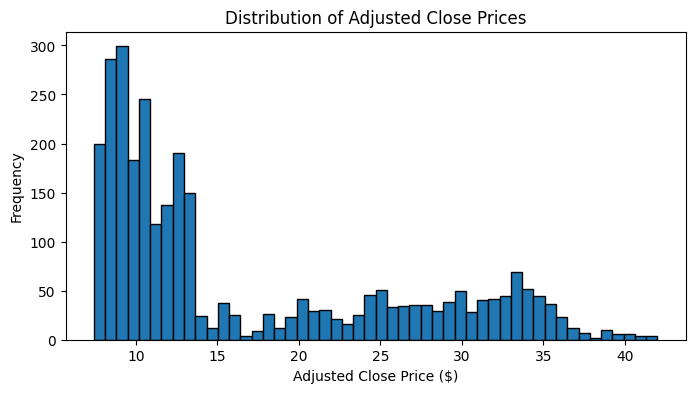

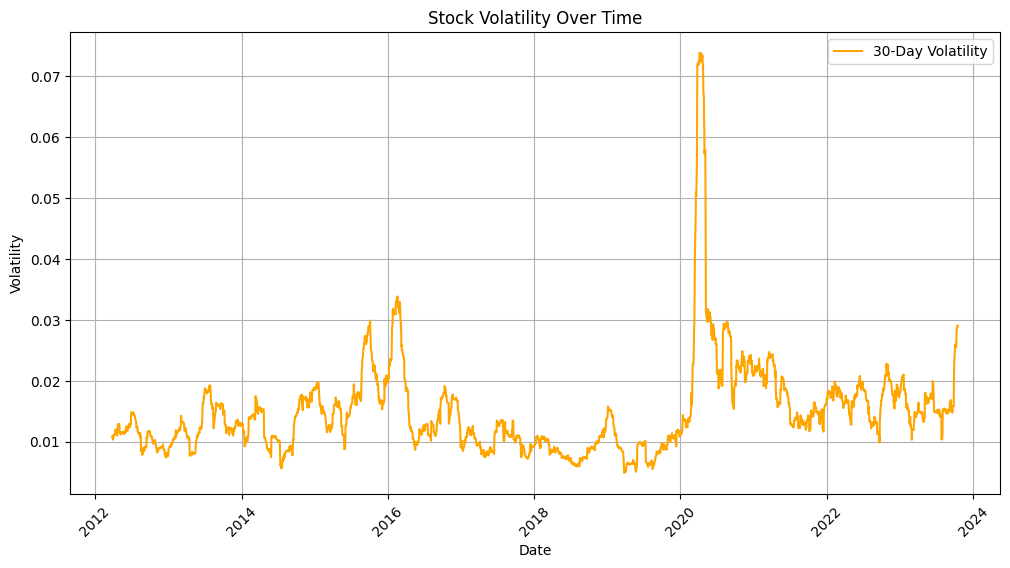

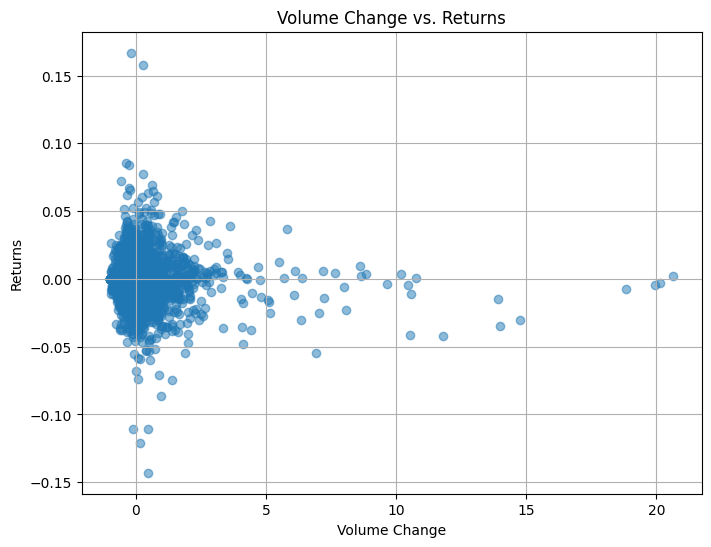

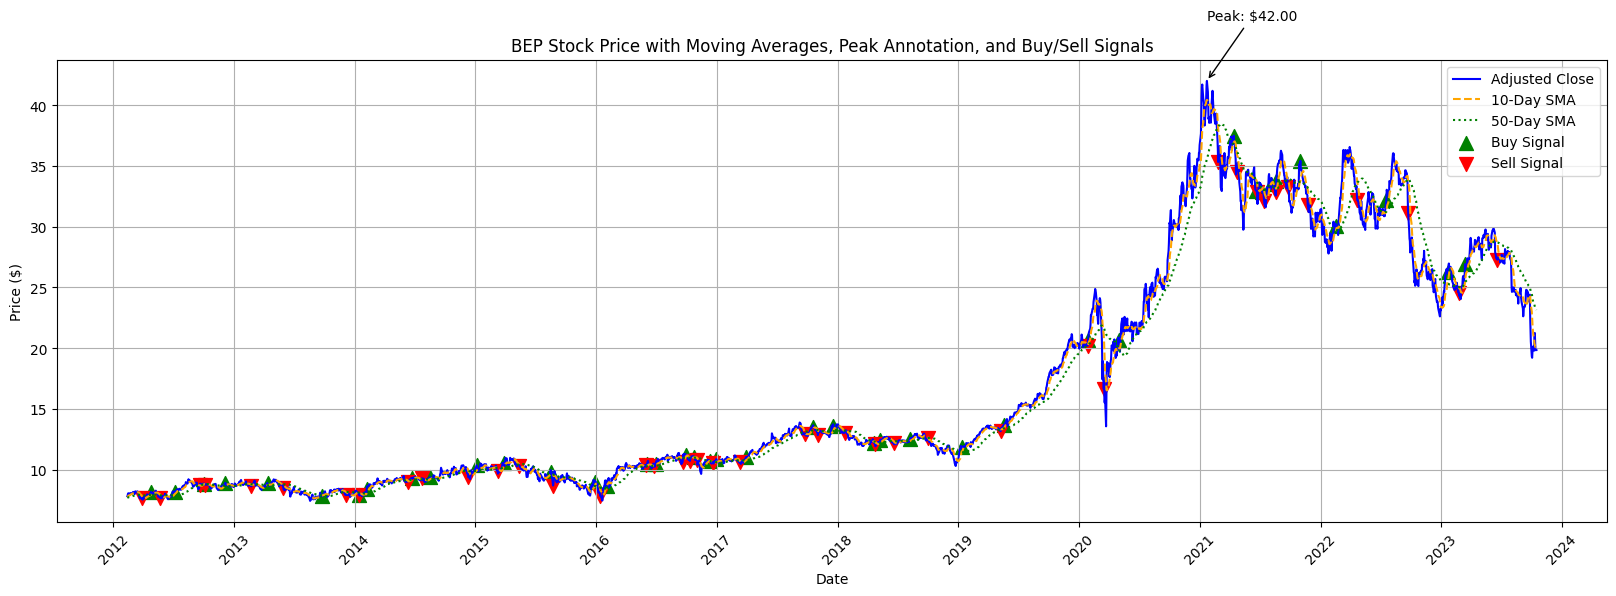

In [4]:
# Ensure that plots are displayed inline
%matplotlib inline

# Load and check the data
BEP_data = pd.read_csv('BEP_daily_stock_data_cleaned.csv', parse_dates=['Date'])
print(BEP_data.head())

# 1. Plot the Distribution of Adjusted Close Prices
plt.figure(figsize=(8, 4))
BEP_data['Adjusted_Close'].hist(bins=50, edgecolor='black')
plt.title('Distribution of Adjusted Close Prices')
plt.xlabel('Adjusted Close Price ($)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# 2. Plot Volatility (30-Day Rolling Standard Deviation of Returns)
BEP_data['Volatility'] = BEP_data['Returns'].rolling(window=30).std()
plt.figure(figsize=(12, 6))
plt.plot(BEP_data['Date'], BEP_data['Volatility'], label='30-Day Volatility', color='orange')
plt.title('Stock Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# 3. Scatter Plot: Volume Change vs. Returns
plt.figure(figsize=(8, 6))
plt.scatter(BEP_data['Volume_Change'], BEP_data['Returns'], alpha=0.5)
plt.title('Volume Change vs. Returns')
plt.xlabel('Volume Change')
plt.ylabel('Returns')
plt.grid(True)
plt.show()
# 4. Comparison of Short-term and Long-term Moving Averages
# Find Buy (bullish) and Sell (bearish) signals
buy_signals = BEP_data[(BEP_data['SMA_10'] > BEP_data['SMA_50']) &
                       (BEP_data['SMA_10'].shift(1) <= BEP_data['SMA_50'].shift(1))]

sell_signals = BEP_data[(BEP_data['SMA_10'] < BEP_data['SMA_50']) &
                        (BEP_data['SMA_10'].shift(1) >= BEP_data['SMA_50'].shift(1))]

# Identify the peak price and its date
max_price_date = BEP_data['Date'][BEP_data['Adjusted_Close'].idxmax()]
max_price = BEP_data['Adjusted_Close'].max()

# Plot Adjusted Close prices and SMAs
plt.figure(figsize=(20, 6))
plt.plot(BEP_data['Date'], BEP_data['Adjusted_Close'], label='Adjusted Close', color='blue')
plt.plot(BEP_data['Date'], BEP_data['SMA_10'], label='10-Day SMA', linestyle='--', color='orange')
plt.plot(BEP_data['Date'], BEP_data['SMA_50'], label='50-Day SMA', linestyle=':', color='green')

# Plot buy signals (bullish crossovers)
plt.scatter(buy_signals['Date'], buy_signals['Adjusted_Close'], marker='^', color='green', s=100, label='Buy Signal')

# Plot sell signals (bearish crossovers)
plt.scatter(sell_signals['Date'], sell_signals['Adjusted_Close'], marker='v', color='red', s=100, label='Sell Signal')

# Annotate the peak price
plt.annotate(f'Peak: ${max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(max_price_date, max_price + 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Set title and labels
plt.title('BEP Stock Price with Moving Averages, Peak Annotation, and Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price ($)')

# Add legend and grid
plt.legend(loc='best')
plt.grid(True)

# Improve x-axis date formatting for readability
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Show the plot
plt.show()

### 3. Prepare Data for Model ###

In [ ]:
# Perform ADF test on original Adjusted_Close prices
result = adfuller(BEP_data['Adjusted_Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:
    print('Series is non-stationary')
else:
    print('Series is stationary')

ADF Statistic: -1.167545
p-value: 0.687399
Series is non-stationary


In [ ]:
# Determine the number of differences needed for stationarity
d = ndiffs(BEP_data['Adjusted_Close'], test='adf')
print(f"Number of differences needed: {d}")
# Load the data from the correct file
BEP_data = pd.read_csv('BEP_daily_stock_data_cleaned.csv')

Number of differences needed: 1


In [ ]:
# Load the data from the correct file
BEP_data = pd.read_csv('BEP_daily_stock_data_cleaned.csv')

# Check the first few rows and column names
print(BEP_data.head())
print(BEP_data.columns)

         Date       Open       High        Low  Adjusted_Close  Volume  \
0  2012-02-13  14.180655  14.281908  14.180655        7.808444    6005   
1  2012-02-14  14.217959  14.361844  14.217959        7.881583    7694   
2  2012-02-15  14.638956  14.644285  14.580336        8.024940    2815   
3  2012-02-16  14.537703  14.676259  14.521716        8.057120   24395   
4  2012-02-17  14.654943  14.692246  14.601652        8.039568    4691   

    Returns  Volume_Change    SMA_10    SMA_50    EMA_10    EMA_50  
0  0.007550       2.199254  7.749639  7.680009  7.769173  7.685891  
1  0.009367       0.281266  7.773044  7.690015  7.789611  7.693565  
2  0.018189      -0.634130  7.805519  7.702537  7.832398  7.706560  
3  0.004010       7.666075  7.841504  7.715643  7.873257  7.720308  
4 -0.002178      -0.807706  7.868420  7.728516  7.903495  7.732828  
Index(['Date', 'Open', 'High', 'Low', 'Adjusted_Close', 'Volume', 'Returns',
       'Volume_Change', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50'],

In [ ]:
# Check the DataFrame index
print(BEP_data.index)
print(type(BEP_data.index))  # Should return <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

RangeIndex(start=0, stop=2924, step=1)
<class 'pandas.core.indexes.range.RangeIndex'>


## 5. Model Implementation ##

In [ ]:
# Load the data from the correct file
BEP_data = pd.read_csv('BEP_daily_stock_data_cleaned.csv')

Adjusted_Close_df = pd.DataFrame(BEP_data)
Adjusted_Close_df

,Date,Open,High,Low,Adjusted_Close,Volume,Returns,Volume_Change,SMA_10,SMA_50,EMA_10,EMA_50
0,2012-02-13,14.180655,14.281908,14.180655,7.808444,6005,0.007550,2.199254,7.749639,7.680009,7.769173,7.685891
1,2012-02-14,14.217959,14.361844,14.217959,7.881583,7694,0.009367,0.281266,7.773044,7.690015,7.789611,7.693565
2,2012-02-15,14.638956,14.644285,14.580336,8.024940,2815,0.018189,-0.634130,7.805519,7.702537,7.832398,7.706560
3,2012-02-16,14.537703,14.676259,14.521716,8.057120,24395,0.004010,7.666075,7.841504,7.715643,7.873257,7.720308
4,2012-02-17,14.654943,14.692246,14.601652,8.039568,4691,-0.002178,-0.807706,7.868420,7.728516,7.903495,7.732828
...,...,...,...,...,...,...,...,...,...,...,...,...
2919,2023-10-10,21.030001,22.290001,21.030001,21.006456,845200,0.061098,0.796769,20.388454,23.538622,20.787273,23.431064
2920,2023-10-11,22.490000,22.820000,22.100000,21.252146,577300,0.011696,-0.316966,20.253324,23.437444,20.871795,23.345616
2921,2023-10-12,22.480000,22.530001,21.690001,20.543427,251500,-0.033348,-0.564351,20.153159,23.349149,20.812092,23.235727
2922,2023-10-13,21.930000,22.120001,20.980000,19.834705,506600,-0.034499,1.014314,20.082286,23.253211,20.634385,23.102353


## LSTM ##

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Replace infinite values with NaN, then handle them by forward and backward filling
BEP_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN (since only 14 rows are affected)
BEP_data.dropna(inplace=True)

In [ ]:
# Select features and target
features = ['Returns', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'Volume_Change']
target = 'Adjusted_Close'

# Prepare the input (X) and target (y)
X = BEP_data[features].values
y = BEP_data[target].values

# Split the data into training (80%) and testing (20%) sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape X to 3D for LSTM: (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")

Training data shape: (2339, 1, 6)
Testing data shape: (585, 1, 6)


In [ ]:
# Define the input shape (1 timestep, number of features)
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])

# Build the Bi-directional LSTM model
model = Sequential()

# Input Layer
model.add(Input(shape=input_shape))

# First Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))  # Dropout for regularization

# Second Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1))  # Predicting one value (future stock price)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 1, 100)              │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,301 (325.39 KB)

 Trainable params: 83,301 (325.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0542 - val_loss: 0.0025
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.9687e-04 - val_loss: 0.0011
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 9.6773e-04
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3239

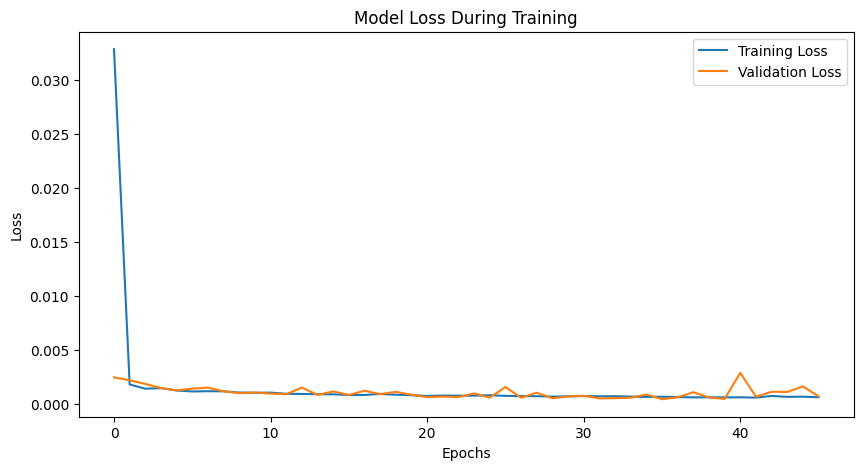

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


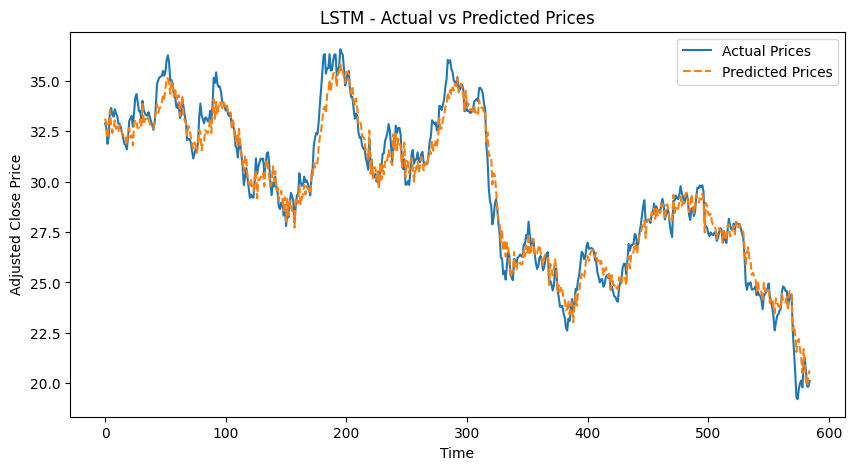

In [ ]:
# Predict on the test set
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform the predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices', linestyle='--')
plt.title('LSTM - Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [ ]:
# Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.536056672782987
Mean Absolute Error: 0.5605345440725994
R2 Score: 0.9639851746752747


In [ ]:
# Save the model in the new Keras format
model.save('lstm_model.keras')